In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint,sample,random as rnd
import networkx as nx
from tqdm.autonotebook import tqdm
from scipy.stats import linregress
from time import time as timer
from scipy.optimize import fsolve

In [150]:
def histo_int(z,nbins=None,logbins=True,density=True):
    if logbins:
        if nbins is None:
            nbins = 50
        xbins = np.unique(np.logspace(0,np.log10(z.max()+2),nbins).astype(int))
    else:
        xbins = np.arange(z.min(),z.max()+2)
    y = np.histogram(z,xbins,density=density)[0]
    nz = y!=0
    return xbins[:-1][nz],y[nz]
def histo_list(Z,nbins=50,logbins=True,density=True,nonezero=True):
    zmax = max([z.max() for z in Z])+2
    zmin = min([z.min() for z in Z])
    if logbins:
        if zmin < 1:
            zmin = 0
        else:
            zmin = np.log10(zmin)
        xbins = np.unique(np.logspace(zmin,np.log10(zmax),nbins).astype(int))
    else:
        xbins = np.arange(zmin,zmax)
    Y = [np.histogram(z,xbins,density=density)[0] for z in Z]
    x = xbins[:-1]
    if nonezero:
        X = [x[y!=0] for y in Y]
        Y = [y[y!=0] for y in Y]
        return X,Y
    return [x]*len(Z),Y

In [71]:
def raise_error_network(n,m,func_name):
    if n <=0 :
        print(f"n must be positive number in "+func_name)
        return True
    elif m <= 0:
        print(f"m must be positive number in "+func_name)
        return True
    elif m >= n:
        print(f"m must be lower than n in "+func_name)
        return True

In [2]:
def biniomial_distro(N,p):
    if p == 1:
        P = np.zeors(N+1)
        P[-1] = 1
        return P
    elif p == 0:
        P = np.zeors(N+1)
        P[0] = 1
        return P
    P = np.zeros(N+1)
    pq = p/(1-p)
    P[0] = (1-p)**N
    for i in range(1,N+1):
        P[i] = P[i-1]*pq*(N-i+1)/i
    return P

In [121]:
def complete_graph_neizonly(n,number_of_empty_nodes=0):
    if n<=0:
        print(f"ERROR: n must be positive number in "+complete_graph_neizonly.__name__)
        return []
    if number_of_empty_nodes>0:
        nrange = list(np.arange(n-number_of_empty_nodes))
        return [nrange[:i]+nrange[i+1:] for i in range(n-number_of_empty_nodes)]+[[] for i in range(number_of_empty_nodes)]
    else:
        nrange = list(np.arange(n))
        return [nrange[:i]+nrange[i+1:] for i in range(n)]
def complete_graph(n,number_of_empty_nodes=0,return_degree=True,return_L=True,return_clustcoef=False,return_adj=False):
    if n<=0:
        print(f"ERROR: n must be positive number in "+complete_graph.__name__)
        return []
    r = [complete_graph_neizonly(n,number_of_empty_nodes)]
    if number_of_empty_nodes>0:
        m = n-number_of_empty_nodes
        if return_degree:
            r.append(np.zeros(n,int))
            r[-1][:m] = m-1
        if return_L:
            r.append(np.zeros(n,int))
            r[-1][:m] = m*(m-1)
        if return_clustcoef:
            r.append(np.zeros(n))
            r[-1][:m] = 1
        if return_adj:
            r.append(np.zeros((n,n),bool))
            r[-1][:m,:m] = True
            r[-1][:m,:m][np.diag_indices(m)] = False
    else:
        if return_degree:
            r.append(np.full(n,n-1,int))
        if return_L:
            r.append(np.full(n,n*(n-1),int))
        if return_clustcoef:
            r.append(np.full(n,1))
        if return_adj:
            r.append(np.ones((n,n),bool))
            r[-1][np.diag_indices(n)] = False
    if len(r) == 1:
        return r[0]
    else:
        return tuple(r)

In [122]:
def new_p_func_4solver(p,n,new_p):
    return n*p/(1-(1-p)**n)-n*new_p
def find_new_p(p_goal,n):
    return fsolve(new_p_func_4solver,x0=p_goal,args=(n,p_goal))[0]

def erdos(n=1000,k=2,directed=False,return_adj=False,return_neiz=True,return_degree=True,connected=True,show_process=False):
    raise_error_network(n,k,erdos.__name__)
    if connected:
        p = k/(n-1)
        p = find_new_p(p,n-1)
        distro = biniomial_distro(n-1,p)[1:]
        distro /= distro.sum()
        nrange_pos = np.arange(1,n)
        degrees = np.random.choice(nrange_pos,size=n,p=distro)
        nodes = list(np.arange(n))
        if return_neiz:
            neiz = [[] for i in range(n)]
            if directed:
                for i in range(n):
                    to_j = np.random.choice(nodes[:i]+nodes[i+1:],degrees[i],replace=False)
                    neiz[i].extend(to_j)
            else:
                degree_sum = degrees.sum()
                if degree_sum%2:
                    if degree_sum > k*n:
                        while True:
                            i = randint(0,n-1)
                            if degrees[i] > 2:
                                degrees[i] -= 1
                                break
                    else:
                        while True:
                            i = randint(0,n-1)
                            if degrees[i] < n-1:
                                degrees[i] += 1
                                break
                degree_remain = degrees.copy()
                degree_remain_sum = degrees[1:].sum()
                for i in range(n-1):
                    # print(degree_remain_sum,degree_remain[i+1:].sum())
                    try:
                        to_j = np.random.choice(nodes[i+1:],size=degree_remain[i],p=degree_remain[i+1:]/degree_remain_sum,replace=False)
                    except:
                        print(i,degree_remain_sum,degree_remain.sum())
                        Q
                    neiz[i].extend(to_j)
                    for j in to_j:
                        neiz[j].append(i)
                        degree_remain[j] -= 1
                    degree_remain_sum -= degree_remain[i]+degree_remain[i+1]
                    if degree_remain_sum == 0:
                        break
        r = [neiz]
        if return_degree:
            r.append(degrees)
        if return_adj:
            adj = np.zeros((n,n),bool)
            for i in range(n):
                adj[i,neiz[i]] = True
            r.append(adj)
        return r[0] if len(r)==1 else r   
    # else:
    #     if return_adj:
    #         p = k/(n-1)
    #         if not directed:
    #             p /= 2
    #             adj = np.random.random((n,n)) < p
    #             adj += adj.T
    #         else:
    #             adj = np.random.random((n,n)) < p
    #         adj[np.diag_indices(n)] = 0
    #         if return_neiz:
    #             return adj,[list(np.where(adj[i])[0]) for i in range(n)],adj.sum(1)
    #         else:
    #             return adj
    #     else:
    #         pass

In [123]:
def BarbasiAlbert_wonx(n=10**4,m=4,return_neiz=True,return_adj=False,return_degree=False):
    if raise_error_network(n,m,BarbasiAlbert_wonx.__name__):
        return False
    neiz = complete_graph_neizonly(n,n-m-1)
    degree = np.zeros(n,int)
    degree[:m+1] = m
    nrange = np.arange(n)
    degree_sum = m*(m+1)
    m2 = m*2
    for i in range(m+1,n):
        probs = degree[:i]/degree_sum
        tolinks = np.random.choice(nrange[:i],size=m,p=probs,replace=False)
        for j in tolinks:
            neiz[i].append(j)
            neiz[j].append(i)
        degree[:i][tolinks] += 1
        degree[i] = m
        degree_sum += m2
    r = [neiz]
    if return_degree:
        r.append(degree)
    if return_adj:
        adj = np.zeros((n,n),bool)
        for i in range(n):
            adj[i,neiz[i]] = True
        r.append(adj)
    return r[0] if len(r) == 1 else r

In [145]:
def sandpile_01(neiz=None,adj=None,degree=None,simt=10**4,loss_per_step=1/10**4,show_process=False):
    if neiz is None:
        if adj is None:
            if degree is None:
                print("ERROR: ")
            else:
                return 0
                # create graph
        else:
            n = len(adj)
            neiz = [np.where(adj[i]) for i in range(n)]
            if degree is None:
                degree = adj.sum(1)
    else:
        if adj is None:
            n = len(neiz)
            adj = np.zeros((n,n),bool)
            for i in range(n):
                adj[i,neiz[i]] = True
                degree = adj.sum(1)
    n = len(neiz)
    z = np.random.random(n)
    z *= degree
    act = np.zeros(n,bool)
    nrange = np.arange(n)
    S = np.zeros(simt)
    T = np.zeros(simt)
    initial_topples = np.random.randint(0,n,simt)
    for t in tqdm(range(simt),disable=not show_process):
        i = initial_topples[t]
        z[i] += 1
        if z[i] > degree[i]:
            act[i] = True
            while act.any():
                actives = nrange[act]
                T[t] += 1
                S[t] += len(actives)
                for i in actives:
                    z[i] -= loss_per_step
                    neiz_i = neiz[i]
                    z[neiz_i] += z[i]/degree[i]
                    z[i] = 0
                    act[i] = False
                    act[neiz_i] = z[neiz_i] > degree[neiz_i]
    return S,T



In [ ]:
def sandpile_02(neiz=None,adj=None,degree=None,simt=10**4,loss_per_step=1/10**4,show_process=False):
    if neiz is None:
        if adj is None:
            if degree is None:
                print("ERROR: ")
            else:
                return 0
                # create graph
        else:
            n = len(adj)
            neiz = [np.where(adj[i]) for i in range(n)]
            if degree is None:
                degree = adj.sum(1)
    else:
        if adj is None:
            n = len(neiz)
            adj = np.zeros((n,n),bool)
            for i in range(n):
                adj[i,neiz[i]] = True
                degree = adj.sum(1)
    n = len(neiz)
    z = np.random.random(n)
    z *= degree
    act = np.zeros(n,bool)
    nrange = np.arange(n)
    S = np.zeros(simt)
    T = np.zeros(simt)
    initial_topples = np.random.randint(0,n,simt)
    act = np.zeros(n,bool)
    l1 = np.zeros(n,int)
    l2 = np.zeros(n,int)
    for t in tqdm(range(simt),disable=not show_process):
        i = initial_topples[t]
        z[i] += 1
        if z[i] > degree[i]:
            act[i] = True
            l1[-1] = 1
            l1[0] = i
            while l1[0]:
                T[t] += 1
                # S[t] += len(actives)
                for i in l1[:l1[-1]]:
                    z[i] -= loss_per_step
                    neiz_i = neiz[i]
                    z[neiz_i] += z[i]/degree[i]
                    z[i] = 0
                    act[i] = False
                    for j in neiz_i:
                        if not act[j] and (z[j] > degree[j]):
                            act[j] = True
                            l2[-1] += 1
                            l2[l2[-1]] = j
                    S[t] += l1[-1]
                l1[-1] = 0
                if l2[-1]:
                    T[t] += 1
                    S[t] += l2[-1]
                    for i in l2[:l2[-1]]:
                        z[i] -= loss_per_step
                        neiz_i = neiz[i]
                        z[neiz_i] += z[i]/degree[i]
                        z[i] = 0
                        act[i] = False
                        for j in neiz_i:
                            if not act[j] and (z[j] > degree[j]):
                                act[j] = True
                                l1[-1] += 1
                                l1[l1[-1]] = j
                    l2[-1] = 0

    return S,T



In [161]:
n = 1000
k = 2
neiz1,degree1,adj1 = BarbasiAlbert_wonx(n=n,m=k,return_degree=1,return_adj=1)
neiz2,degree2,adj2 = erdos(n=n,k=k,return_degree=1,return_adj=1)

In [ ]:
sandpile_01(neiz1,adj1,degree1,simt=100,show_process=1,loss_per_step=0.0001)
sandpile_02(neiz1,adj1,degree1,simt=100,show_process=1,loss_per_step=0.0001)

In [164]:
S1,T1 = sandpile(neiz1,adj1,degree1,simt=10000,show_process=1,loss_per_step=0.0001)
S2,T2 = sandpile(neiz2,adj2,degree2,simt=10000,show_process=1,loss_per_step=0.0001)

100%|██████████| 10000/10000 [44:42<00:00,  3.73it/s]  


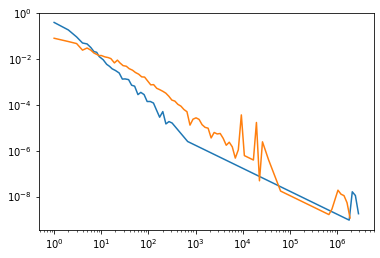

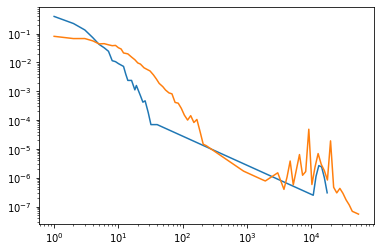

In [166]:
plt.loglog()
plt.plot(*histo_int(S1,nbins=100))
plt.plot(*histo_int(S2,nbins=100))
plt.show()

plt.loglog()
plt.plot(*histo_int(T1,nbins=100))
plt.plot(*histo_int(T2,nbins=100))
plt.show()